In [3]:
from pylab import *
import scipy.io as spio # using wavfile for reading and writing wavefiles 
import scipy.io.wavfile
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm #to keep track of iterations

import sys
import wave
import math
import scipy.signal
from scipy.signal import lfilter, hamming
import librosa

import librosa.display
import librosa.feature
import IPython.display as ipd
%matplotlib inline

import pylab

## Question 1

In [ ]:
#importing libraries
from pylab import *
import scipy.io as spio # using wavfile for reading and writing wavefiles 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import cmath
from tqdm import tqdm #to keep track of iterations

#*********** Reusing piece of original code I had used for a project in the course adaptive signal processing**********
def lowpass_filter(data,cutoff,fs,order): #data= input, cutoff = filter cutoff freq, fs=sampling freq, order = filter order
    nyq = 0.5*fs #nyquist freq
    normalized_cutoff = cutoff/nyq #done this way since the butterworth filter fn accepts normalized cutoff only
    #filter coefficients
    b, a = sig.butter(order,normalized_cutoff,btype ='low', analog = False) #numerator and denom of filter
    y = sig.lfilter(b,a,data) #returns response from filter
    return y

def Ps(data,p,l_ambda): #predictor based on spectral envelope with p coefficients ,I'm using p<len(data) which is the norm
    r = np.zeros(p)
    a = np.zeros(p) #predictor coefficients
    t = np.zeros(p) #temporary coefficients
    k = np.zeros(p) #reflection coefficients
    x = np.correlate(data,data,'full') #autocorrelation of speech expressed as a vector,has 2*(len)-1 elements
    r = x[len(data)-1:len(data)+p-1]
    
    #having done this, we gotta implement regularization phi_n[i][j] =phi[i][j] +lambda*emin*u[i-j]
    emin = levinson_durbin(r)[1]
    u    = np.zeros(p)    #autocorrelation of high pass filtered white noise
    u[:3]= [3/8,1/4,1/16]
    phi = sp.linalg.toeplitz(r)
    phi_n = np.zeros((p,p))
    
    for i in range(p):
        for j in range(p):
            phi_n[i][j] = phi[i][j] + l_ambda*emin*u[i-j]
    
    L = np.linalg.cholesky(phi_n) #since inversion is time consuming
    r_n = r + l_ambda*emin*u
    
    q = np.linalg.lstsq(L,r_n,rcond = None)[0]
    #print(q)
    
    #generating parcor coefficients or reflection coefficients
    r_p = (1/np.sqrt((np.abs(data[0])**2 + np.linalg.norm(q)**2)))*q
    
    a[0] = 1. #initialization
    e = r_n[0]  # e is the mse 

    for i in range(1,p):

        for j in range(1, i):
            k[i-1] = r_p[i-1]
            a[i] = k[i-1]

        for j in range(len(r)-1):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])  #mse

    coeff = np.zeros(p+1)
    #coeff[1:] = a  #since its an allpole filter
    coeff = a
    return coeff,phi,e

def levinson_durbin(r):   #levinson_durbin recursion to find the predictor coefficients using the lattice method
    # Estimated coefficients
    a = np.zeros(len(r))
    # temporary array
    t = np.zeros(len(r))
    # Reflection coefficients
    k = np.zeros(len(r))

    a[0] = 1. #initialization
    e = r[0]  # e is the mse 

    for i in range(1,len(r)):
        acc = r[i]   #auto correlation coefficient
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k[i-1] = -acc / e
        a[i] = k[i-1]

        for j in range(len(r)-1):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])  #mse

    return a, e, k

#*************************** Back to Speech Tech **********************************

Audio_in = 'Mask.wav' # input audio file
fs,data  = spio.wavfile.read(Audio_in)  #fs = initial sampling freq of the source,data = corresponding numpy array
Fs= 8000 #final sampling frequency
Ps_order = 12 #assuming 6 formants
Ps_lambda = 0.05 # normalization to prevent low eigenvalues

#passing the speech signal through a second order lowpass filter to get rid of higher order frequencies (more efficient)
cutoff = 3400 #3.4 Khz
order = 2
y= lowpass_filter(data,cutoff,fs,order)
s = y[::int(fs/Fs)] #sampling instead Fs instead of the original rate fs
N_sample = len(s) # total number of samples in the speech file
N_frame  = int(Fs*(20e-3)) #taking speech frames of duration 20 ms
niter    = int(N_sample/N_frame) + 1 #total number of frames under consideration

pred_coeff = np.zeros((niter,Ps_order))
d      = np.zeros(niter*N_frame) #predicted speech signal
H      = np.zeros(Fs) #dft of filter coefficients
w = linspace(0,np.pi*Fs,Fs//2 + 1) #freq

#creating Hamming Window

Hamming_wind = np.hamming(N_frame)


for i in tqdm(range(niter)):
    s_frame = np.zeros(N_frame)
    
    #last initialization
    if(i==niter-1):
        Nex = len(s)-i*N_frame #All the leftover values to prevent size mismatch in evaluation
        s_frame[0:Nex] = s[i*N_frame:]
    else:
        s_frame = s[i*N_frame:(i+1)*N_frame]
        
    #calculating the linear prediction coefficients for a frame
    pred_coeff[i] = Ps(s_frame,Ps_order,Ps_lambda)[0]
    
    #computing error signal
    d[i*N_frame:(i+1)*N_frame] = s_frame - sig.lfilter(pred_coeff[i],1,s_frame) #difference signal
    
    #computing DFT for this portion of the error signal
    #zero padding error signal
    d_pad = np.zeros(int(Fs))
    d_pad[0:N_frame] = d[i*N_frame:(i+1)*N_frame]

    E = np.fft.fft(d_pad)  # DFT of error frame
    
    #computing DFT for the predictor coeff
    h_pad = np.zeros(int(Fs))
    h_pad[0:Ps_order] = pred_coeff[i]
    H = np.fft.fft(h_pad)
    Z += E/H
    
    
    

#zero padding s
s_pad = np.zeros(int(Fs))
s_pad[0:N_sample] = s
S = np.fft.fft(s_pad)  # DFT of speech spectrum

print(Z)




    
    

plt.plot(np.abs(S[:int(len(S)/2)]))
plt.plot(np.abs(Z[:int(len(Z)/2)]))
plt.grid()
plt.show()



In [ ]:
import librosa
#plot for question 1

#taking a random frame of speech

s_frame = s[10*N_frame:11*N_frame]

#convolving with Hamming window

#creating Hamming Window
Hamming_wind = np.hamming(N_frame)

s_out = sig.lfilter(Hamming_wind,1,s_frame)

#performing linear prediction on this frame of speech
#P_coeff = np.zeros(Ps_order)
#P_coeff =  Ps(s_frame,Ps_order,Ps_lambda)[0]
#error_gain = Ps(s_frame,Ps_order,Ps_lambda)[2]

#computing P_coeff using librosa library
P_coeff = librosa.lpc(s_out,Ps_order)
print(P_coeff)
#plotting the DFT spectrum of the frame of speech
#zero padding s
s_pad = np.zeros(int(Fs))
s_pad[0:N_frame] = s_out
S = np.fft.fft(s_pad)  # DFT of speech spectrum

plt.semilogx(20*log10(np.abs(S[:int(len(S)/2)])))
plt.show()

#plotting the LPC outlining envelope
print(P_coeff)
#P_coeff[1:] *= -1 
print(P_coeff)

w_LPC,LPC = sig.freqz(b=1.0,a=P_coeff,worN = N_frame,fs = Fs)

energy = 0
for i in s_out:
    energy+= i*np.conj(i)
    
energy = np.sqrt(energy/N_frame)
    

plt.semilogx(20*log10(np.abs(S[:int(len(S)/2)])),color = 'orange',label='DFT Spectrum of Speech Frame')
plt.semilogx(w_LPC/2,20*log10((energy*np.abs(LPC))),label ="LPC Spectrum")
plt.legend()
plt.xlabel('w ->')
plt.ylabel('Magnitude in dB')
plt.grid()
plt.title('LPC Spectrum and DFT Spectrum of a particular speech frame')
plt.show()

Question 2

In [5]:
#**** Reusing piece of original code I had used for a project in the course adaptive signal processing***
def lowpass_filter(data,cutoff,fs,order): #data= input, cutoff = filter cutoff freq, fs=sampling freq, order = filter order
    nyq = 0.5*fs #nyquist freq
    normalized_cutoff = cutoff/nyq #done this way since the butterworth filter fn accepts normalized cutoff only
    #filter coefficients
    b, a = sig.butter(order,normalized_cutoff,btype ='low', analog = False) #numerator and denom of filter
    y = sig.lfilter(b,a,data) #returns response from filter
    return y

def Ps(data,p,l_ambda): #predictor based on spectral envelope with p coefficients ,I'm using p<len(data) which is the norm
    r = np.zeros(p)
    a = np.zeros(p) #predictor coefficients
    t = np.zeros(p) #temporary coefficients
    k = np.zeros(p) #reflection coefficients
    x = np.correlate(data,data,'full') #autocorrelation of speech expressed as a vector,has 2*(len)-1 elements
    r = x[len(data)-1:len(data)+p-1]
    
    #having done this, we gotta implement regularization phi_n[i][j] =phi[i][j] +lambda*emin*u[i-j]
    emin = levinson_durbin(r)[1]
    u    = np.zeros(p)    #autocorrelation of high pass filtered white noise
    u[:3]= [3/8,1/4,1/16]
    phi = sp.linalg.toeplitz(r)
    phi_n = np.zeros((p,p))
    
    for i in range(p):
        for j in range(p):
            phi_n[i][j] = phi[i][j] + l_ambda*emin*u[i-j]
    
    L = np.linalg.cholesky(phi_n) #since inversion is time consuming
    r_n = r + l_ambda*emin*u
    
    q = np.linalg.lstsq(L,r_n,rcond = None)[0]
    #print(q)
    
    #generating parcor coefficients or reflection coefficients
    r_p = (1/np.sqrt((np.abs(data[0])*2 + np.linalg.norm(q)*2)))*q
    
    a[0] = 1. #initialization
    e = r_n[0]  # e is the mse 

    for i in range(1,p):

        for j in range(1, i):
            k[i-1] = r_p[i-1]
            a[i] = k[i-1]

        for j in range(len(r)-1):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])  #mse

    coeff = np.zeros(p+1)
    #coeff[1:] = a  #since its an allpole filter
    coeff = a
    return coeff,phi,e

def levinson_durbin(r):   #levinson_durbin recursion to find the predictor coefficients using the lattice method
    # Estimated coefficients
    a = np.zeros(len(r))
    # temporary array
    t = np.zeros(len(r))
    # Reflection coefficients
    k = np.zeros(len(r))

    a[0] = 1. #initialization
    e = r[0]  # e is the mse 

    for i in range(1,len(r)):
        acc = r[i]   #auto correlation coefficient
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k[i-1] = -acc / e
        a[i] = k[i-1]

        for j in range(len(r)-1):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])  #mse

    return a, e, k

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 633.25it/s]


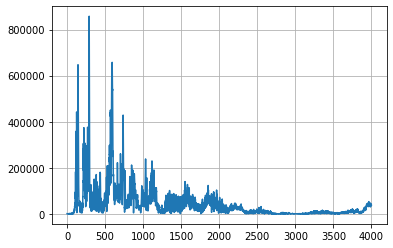

In [6]:
#********* Back to Speech Tech ************

Audio_in = 'Mask.wav' # input audio file
fs,data  = scipy.io.wavfile.read(Audio_in)  #fs = initial sampling freq of the source,data = corresponding numpy array
Fs= 8000 #final sampling frequency
Ps_order = 12 #assuming 6 formants
Ps_lambda = 0.05 # normalization to prevent low eigenvalues

#passing the speech signal through a second order lowpass filter to get rid of higher order frequencies (more efficient)
cutoff = 3400 #3.4 Khz
order = 2
y= lowpass_filter(data,cutoff,fs,order)
s = y[::int(fs/Fs)] #sampling instead Fs instead of the original rate fs
N_sample = len(s) # total number of samples in the speech file
N_frame  = int(Fs*(20e-3)) #taking speech frames of duration 20 ms
niter    = int(N_sample/N_frame) + 1 #total number of frames under consideration

pred_coeff = np.zeros((niter,Ps_order))
d      = np.zeros(niter*N_frame) #predicted speech signal
H      = np.zeros(Fs) #dft of filter coefficients
w = linspace(0,np.pi*Fs,Fs//2 + 1) #freq

for i in tqdm(range(niter)):
    s_frame = np.zeros(N_frame)
    
    #last initialization
    if(i==niter-1):
        Nex = len(s)-i*N_frame #All the leftover values to prevent size mismatch in evaluation
        s_frame[0:Nex] = s[i*N_frame:]
    else:
        s_frame = s[i*N_frame:(i+1)*N_frame]
        
    #calculating the linear prediction coefficients for a frame
    pred_coeff[i] = Ps(s_frame,Ps_order,Ps_lambda)[0]
    
    #computing error signal
    d[i*N_frame:(i+1)*N_frame] = s_frame - sig.lfilter(pred_coeff[i],1,s_frame) #difference signal
    
    #computing piecewise H(e^jw)
    
    

#zero padding s
s_pad = np.zeros(int(Fs))
s_pad[0:N_sample] = s

S = np.fft.fft(s_pad)  # DFT of speech spectrum


#zero padding error signal
d_pad = np.zeros(int(Fs))
d_pad[0:len(d)] = d

E = np.fft.fft(d_pad)  # DFT of error spectrum



plt.plot(np.abs(S[:int(len(S)/2)]))
plt.grid()
plt.show()

In [7]:
print(pred_coeff)

[[ 1.00000000e+00 -1.36266837e-26  7.05488334e-14 -1.14205653e-13
   3.96783006e-14  8.97030140e-15 -2.08554966e-14  3.54200358e-14
  -1.17719686e-14 -1.15648699e-14  4.71205162e-14  7.58691237e-15]
 [ 1.00000000e+00 -3.66956105e-27 -6.43877725e-14  1.41062077e-13
   1.17296975e-13 -5.58000360e-14  2.96419836e-14 -2.29374079e-15
  -6.01909366e-14  4.13999865e-14 -1.94427766e-14 -1.50657187e-14]
 [ 1.00000000e+00 -3.99559094e-27  6.18272597e-14 -4.57895799e-14
   2.65162375e-14  2.17426295e-15 -1.69421812e-14  4.73317758e-15
   2.03278408e-14  1.29402710e-15 -1.49405365e-15  7.75888555e-15]
 [ 1.00000000e+00 -6.38893300e-27  1.38998054e-13 -4.34417398e-14
   6.06787995e-15  4.95295472e-16 -2.93566974e-14  9.46196436e-16
   9.38756836e-15  3.96055410e-15 -6.24477478e-15  1.10546975e-14]
 [ 1.00000000e+00 -3.97261196e-26  1.96706666e-13 -1.31127849e-13
   6.47803379e-14 -6.09869300e-14 -5.75938879e-14  2.53955038e-14
   5.13418725e-14 -7.98647146e-14  1.16339349e-14  1.62203375e-14]
 [ 1.

In [8]:
frames = {}

def formant_freq(x):
    rts = np.roots(x)
    rts = rts[np.imag(rts) >= 0]
    angz = np.arctan2(np.imag(rts), np.real(rts))
    frqs = angz * fs / (2 *  np.pi)
    frqs.sort()
    frqs = frqs.tolist()
    return frqs

for i in range(36):
    x = pred_coeff[i]
    frames[i] = formant_freq(x)
    

In [9]:
print(frames)

{0: [743.611822408157, 2228.6543186649815, 3705.9369085549497, 5166.319481626587, 6597.828474563468, 7999.999999999999], 1: [0.0, 1461.5371963971472, 2922.242373517928, 4380.4432890082635, 5833.24255867711, 7278.9334947804155], 2: [726.7361684634142, 2180.202407027022, 3634.0095618864107, 5088.699569861112, 6544.195483019512, 7999.999999999999], 3: [725.3978104214203, 2176.6656779926793, 3629.4033744495605, 5084.3782815678815, 6541.541448798255, 7999.999999999999], 4: [728.0426096502721, 2185.2878366430396, 3644.2871438448724, 5102.038859150573, 6554.069196249846, 7999.999999999999], 5: [710.7871460976082, 2151.415311615383, 3621.879551579335, 5101.887593194991, 6564.85527765632, 7999.999999999999], 6: [722.4987715629252, 2169.2686444678525, 3620.5035655022666, 5076.952701210646, 6537.471738799449, 7999.999999999999], 7: [733.3805101023742, 2199.154131222248, 3661.5035646571646, 5116.952406605737, 6562.515817471775, 7999.999999999999], 8: [0.0, 1459.2723613436203, 2917.544144351731, 43

In [10]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
for k,v in frames.items():
    l1.append(v[0])
    l2.append(v[1])
    l3.append(v[2])
    l4.append(v[3])
    l5.append(v[4])
    l6.append(v[5])

In [11]:
x = []
for i in range(36):
    i = i+1
    x.append(i)

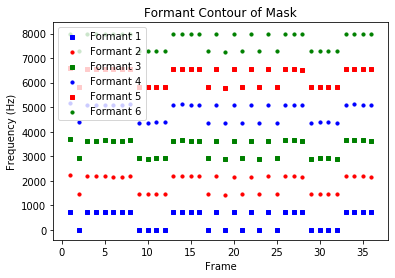

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, l1, s=10, c='b', marker="s", label='Formant 1')
ax1.scatter(x, l2, s=10, c='r', marker="o", label='Formant 2')
ax1.scatter(x, l3, s=10, c='g', marker="s", label='Formant 3')
ax1.scatter(x, l4, s=10, c='b', marker="o", label='Formant 4')
ax1.scatter(x, l5, s=10, c='r', marker="s", label='Formant 5')
ax1.scatter(x, l6, s=10, c='g', marker="o", label='Formant 6')
plt.legend(loc='upper left');
plt.title("Formant Contour of Mask")
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.show()

Question 3

In [13]:
wave, fs = librosa.load('Mask.wav', sr=None)

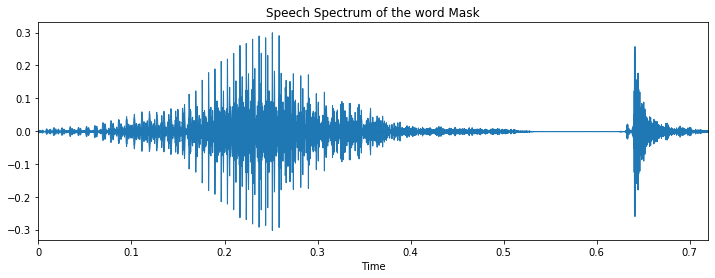

In [43]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)
plt.title('Speech Spectrum of the word Mask')
plt.show()

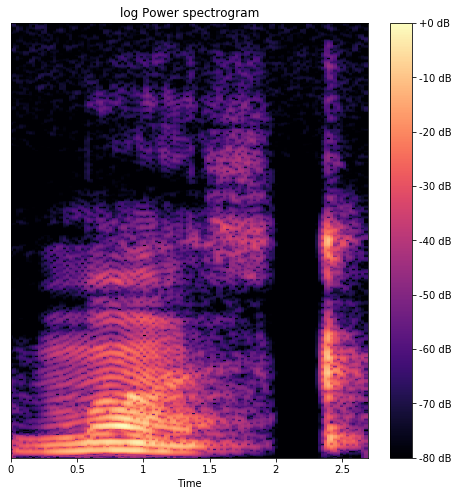

In [15]:
mag, phase = librosa.magphase(librosa.stft(wave, n_fft=1024, win_length=400))
plt.figure(figsize=(8,8))
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max), x_axis='time units')
plt.title('log Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [16]:
'''
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rms(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)
'''

zrc = librosa.feature.zero_crossing_rate(wave, threshold=0)
zrc = zrc[0]

In [17]:
'''
, frame_length=frame_len, hop_length=frame_shift'''

'\n, frame_length=frame_len, hop_length=frame_shift'

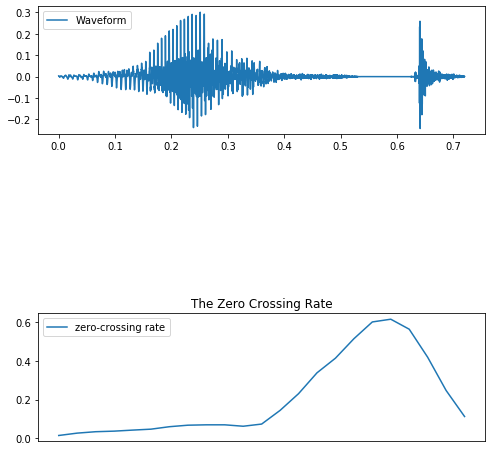

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-crossing rate')
plt.title("The Zero Crossing Rate")
plt.xticks([])
plt.legend(loc='best')
plt.show()

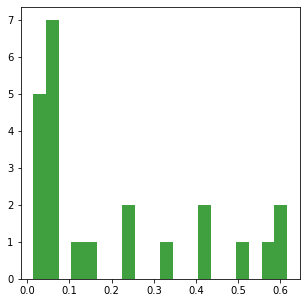

In [19]:
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(zrc.T, 20, facecolor='g', alpha=0.75)

In [20]:
frame_idxs = np.where( (zrc > 0.1) )[0]

In [21]:
def getboundaries(frame_idxs):
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    shapeofidxs = np.shape(frame_idxs)
    for i in range(shapeofidxs[0]-1):
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])

    end_idxs.append(frame_idxs[-1])
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

start_t, end_t = getboundaries(frame_idxs)


plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()


NameError: name 'frame_shift' is not defined

In [22]:
def _sgn(x):
  y = numpy.zeros_like(x)
  y[numpy.where(x >= 0)] = 1.0
  y[numpy.where(x < 0)] = -1.0
  return y


def ste(x, win):
  if isinstance(win, str):
    win = scipy.signal.get_window(win, max(1, len(x) // 8))
  win = win / len(win)
  return scipy.signal.convolve(x**2, win**2, mode="same")

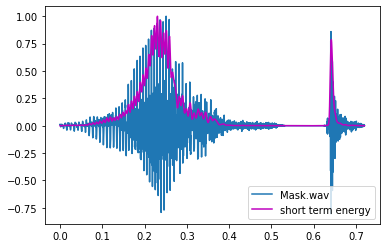

In [23]:
fs, x = scipy.io.wavfile.read("Mask.wav")
x = np.array(x, dtype=float)
t = np.arange(len(x)) * (1.0 / fs)

# Find the short time energy.
e = ste(x, scipy.signal.get_window("hamming", 201))

pylab.figure()
pylab.plot(t, x / x.max(), label="Mask.wav")
#pylab.hold(True)
pylab.plot(t, e / e.max(), 'm', label="short term energy")
pylab.legend()

In [24]:
frame_idxs = np.where( (e > 0.2) )[0]

start_t2, end_t2 = getboundaries(frame_idxs)


plt.figure(figsize=(12, 4))
#t = np.linspace(0, len(wave)/fs, len(wave))
pylab.plot(t, x / x.max(), label="Mask.wav")
#plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t2, end_t2):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()


NameError: name 'frame_shift' is not defined

In [25]:
rts = np.roots(pred_coeff[35])
rts = rts[np.imag(rts) >= 0]
angz = np.arctan2(np.imag(rts), np.real(rts))
frqs = angz * fs / (2 *  np.pi)
frqs.sort()
print(frqs)

[ 724.55865946 2173.18724695 3622.39478953 5075.85299996 6535.69409047
 8000.        ]


In [26]:
#A = librosa.core.lpc(data, 12)
def formant_freq(x):
    rts = np.roots(x)
    rts = rts[np.imag(rts) >= 0]
    angz = np.arctan2(np.imag(rts), np.real(rts))
    frqs = angz * fs / (2 *  np.pi)
    frqs.sort()
    frqs = frqs.tolist()
    return frqs

l1 = [[0]*36]*6
for i in range(36):
    frqs = formant_freq(pred_coeff[i])
    for j in range(6):
        l1[[j][i]] = frqs[j]

IndexError: list index out of range

## Question 4

In [42]:
#pitch prediction :run this after running 1st question
def Pitch_pred(d):
    x = np.correlate(d,d,'full') #autocorrelation of speech expressed as a vector,has 2*(len)-1 elements
    #find index of max correlation to find m
    x = x[x.size//2:]
    M = np.where(x == x[4:].max()) #ignoring first element of autocorrelation vector
    return M[0]

pitch = np.zeros(niter)

for i in tqdm(range(niter)):
        s_frame = np.zeros(N_frame)
    
        #last initialization
        if(i==niter-1):
            Nex = len(s)-i*N_frame #All the leftover values to prevent size mismatch in evaluation
            s_frame[0:Nex] = s[i*N_frame:]
        else:
            s_frame = s[i*N_frame:(i+1)*N_frame]
            
        pitch[i] = int(50*N_frame/Pitch_pred(s_frame)[0])
        
        
        
plt.plot(pitch, 'o',label = 'pitch')
plt.title('Pitch estimation through autocorrelation method')
plt.xlabel('Samples')
plt.ylabel('Pitch Frequency (Hz)')
plt.grid()
plt.legend()          
plt.show()
        

  0%|                                                                                           | 0/77 [00:00<?, ?it/s]


ValueError: first array argument cannot be empty

## Question 5

In [32]:
import librosa
wave2, fs2 = librosa.load('sent_male.wav', sr=None)
wave3, fs3 = librosa.load('sent_female.wav',sr = None)

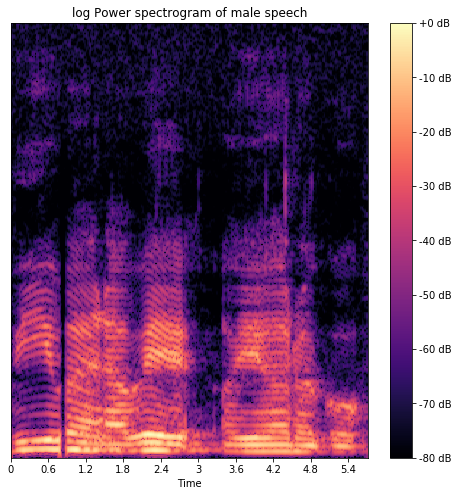

In [33]:
mag, phase = librosa.magphase(librosa.stft(wave2, n_fft=1024, win_length=400))
plt.figure(figsize=(8,8))
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max), x_axis='time units')
plt.title('log Power spectrogram of male speech')
plt.colorbar(format='%+2.0f dB')
plt.show()

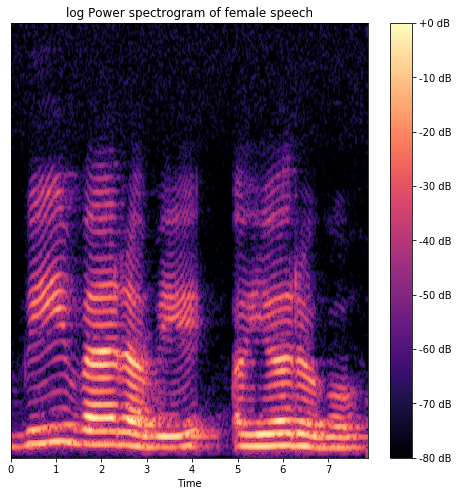

In [34]:
mag, phase = librosa.magphase(librosa.stft(wave3, n_fft=1024, win_length=400))
plt.figure(figsize=(8,8))
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max), x_axis='time units')
plt.title('log Power spectrogram of female speech')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [35]:
frames = {}

def formant_freq(x):
    rts = np.roots(x)
    rts = rts[np.imag(rts) >= 0]
    angz = np.arctan2(np.imag(rts), np.real(rts))
    frqs = angz * fs / (2 *  np.pi)
    frqs.sort()
    frqs = frqs.tolist()
    return frqs

for i in range(36):
    x = pred_coeff[i]
    frames[i] = formant_freq(x)


In [41]:
Ps_order = 12 #assuming 6 formants
Ps_lambda = 0.05 # normalization to prevent low eigenvalues

#pitch prediction
def Pitch_pred(d):
    x = np.correlate(d,d,'full') #autocorrelation of speech expressed as a vector,has 2*(len)-1 elements
    #find index of max correlation to find m
    x = x[x.size//2:]
    M = np.where(x == x[4:].max()) #ignoring first element of autocorrelation vector
    return M[0]

pitch = np.zeros(niter)


#passing the speech signal through a second order lowpass filter to get rid of higher order frequencies (more efficient)
cutoff = 3400 #3.4 Khz
order = 2
y= lowpass_filter(wave2,cutoff,fs2,order)
s2 = y[::int(fs/Fs)] #sampling instead Fs instead of the original rate fs
N_sample = len(s2) # total number of samples in the speech file
N_frame  = int(Fs*(20e-3)) #taking speech frames of duration 20 ms
niter    = int(N_sample/N_frame) + 1 #total number of frames under consideration
Hamming_wind = np.hamming(N_frame)
frames = {}

for i in range(niter):
    s_frame = np.zeros(N_frame)
    
    #last initialization
    if(i==niter-1):
        Nex = len(s)-i*N_frame #All the leftover values to prevent size mismatch in evaluation
        s_frame[0:Nex] = s[i*N_frame:]
    else:
        s_frame = s[i*N_frame:(i+1)*N_frame]
        
    s_out = sig.lfilter(Hamming_wind,1,s_frame) #using Hamming Window
    
    coeff = librosa.lpc(s_out,Ps_order)
    
    frames[i] = formant_freq(coeff)
    pitch[i] = int(50*N_frame/Pitch_pred(s_frame)[0])
    
    
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
for k,v in frames.items():
    l1.append(v[0])
    l2.append(v[1])
    l3.append(v[2])
    l4.append(v[3])
    l5.append(v[4])
    l6.append(v[5])        
    
    

ValueError: v cannot be empty

[ 1.         -3.13242914  4.25128442 -3.64773205  2.70846715 -2.14562655
  2.26428115 -3.015009    3.29151351 -2.80299543  2.07717456 -1.18507162
  0.33789517]


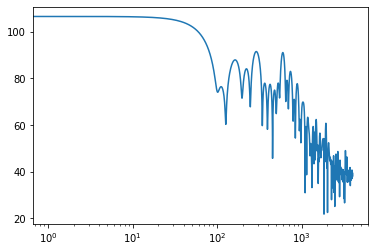

[ 1.         -3.13242914  4.25128442 -3.64773205  2.70846715 -2.14562655
  2.26428115 -3.015009    3.29151351 -2.80299543  2.07717456 -1.18507162
  0.33789517]
[ 1.         -3.13242914  4.25128442 -3.64773205  2.70846715 -2.14562655
  2.26428115 -3.015009    3.29151351 -2.80299543  2.07717456 -1.18507162
  0.33789517]


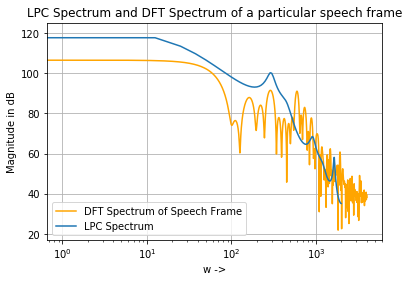

In [40]:
import librosa
#plot for question 1

#taking a random frame of speech

s_frame = s[10*N_frame:11*N_frame]

#convolving with Hamming window

#creating Hamming Window
Hamming_wind = np.hamming(N_frame)

s_out = sig.lfilter(Hamming_wind,1,s_frame)

#performing linear prediction on this frame of speech
#P_coeff = np.zeros(Ps_order)
#P_coeff =  Ps(s_frame,Ps_order,Ps_lambda)[0]
#error_gain = Ps(s_frame,Ps_order,Ps_lambda)[2]

#computing P_coeff using librosa library
P_coeff = librosa.lpc(s_out,Ps_order)
print(P_coeff)
#plotting the DFT spectrum of the frame of speech
#zero padding s
s_pad = np.zeros(int(Fs))
s_pad[0:N_frame] = s_out
S = np.fft.fft(s_pad)  # DFT of speech spectrum

plt.semilogx(20*log10(np.abs(S[:int(len(S)/2)])))
plt.show()

#plotting the LPC outlining envelope
print(P_coeff)
#P_coeff[1:] *= -1 
print(P_coeff)

w_LPC,LPC = sig.freqz(b=1.0,a=P_coeff,worN = N_frame,fs = Fs)

energy = 0
for i in s_out:
    energy+= i*np.conj(i)
    
energy = np.sqrt(energy/N_frame)
    

plt.semilogx(20*log10(np.abs(S[:int(len(S)/2)])),color = 'orange',label='DFT Spectrum of Speech Frame')
plt.semilogx(w_LPC/2,20*log10((energy*np.abs(LPC))),label ="LPC Spectrum")
plt.legend()
plt.xlabel('w ->')
plt.ylabel('Magnitude in dB')
plt.grid()
plt.title('LPC Spectrum and DFT Spectrum of a particular speech frame')
plt.show()

In [ ]:
#pitch prediction
def Pitch_pred(d):
    x = np.correlate(d,d,'full') #autocorrelation of speech expressed as a vector,has 2*(len)-1 elements
    #find index of max correlation to find m
    x = x[x.size//2:]
    M = np.where(x == x[4:].max()) #ignoring first element of autocorrelation vector
    return M[0]

pitch = np.zeros(niter)

for i in tqdm(range(niter)):
        s_frame = np.zeros(N_frame)
    
        #last initialization
        if(i==niter-1):
            Nex = len(s)-i*N_frame #All the leftover values to prevent size mismatch in evaluation
            s_frame[0:Nex] = s[i*N_frame:]
        else:
            s_frame = s[i*N_frame:(i+1)*N_frame]
            
        pitch[i] = int(50*N_frame/Pitch_pred(s_frame)[0])
        
        
        
plt.plot(pitch, 'o',label = 'pitch')
plt.title('Pitch estimation through autocorrelation method')
plt.xlabel('Samples')
plt.ylabel('Pitch Frequency (Hz)')
plt.grid()
plt.legend()          
plt.show()